# 2. POS tagging with HMMs

## Preparation

In [1]:
import matplotlib.pyplot as plt

from hmm_pos_tagger import HmmPosTaggerInterface, HmmNgramPosTagger
from hmm_pos_tagger import HmmPosTagger, HmmMaskedPosTagger, UnsupervisedHmmPosTagger
from dataset import load_dataset_ud_german_gsd, ALL_POS_TAGS

from copy import deepcopy
import time

def run_tagging(model: HmmPosTaggerInterface, sentences: list, labels: list) -> tuple[float, float]:
    seconds = time.time()
    predicts = model.tag(sentences)
    seconds = time.time() - seconds

    predicts = [x for xx in predicts for x in xx]
    targets = [x for xx in labels for x in xx]
    assert len(predicts) == len(targets)

    same_cnt = 0
    for pred, targ in zip(predicts, targets):
        same_cnt += targ == pred[0]
    return same_cnt / len(predicts) * 100, seconds * 1000

In [2]:
# Load datasets
train_set = load_dataset_ud_german_gsd("train", return_labels=True)
dev_set = load_dataset_ud_german_gsd("dev", return_labels=True)
test_set = load_dataset_ud_german_gsd("test", return_labels=True)
words_set = {x for xx in train_set["sentences"] for x in xx}

def report_dataset_info(sentences: list[list[str]]):
    sum_length, max_length, min_length = 0, 0, 1<<31
    for words_list in sentences:
        length = len(words_list)
        sum_length += length
        max_length = max(max_length, length)
        min_length = min(min_length, length)
    return len(sentences), int(round(sum_length / len(sentences))), max_length, min_length

print("| split | sentences | Lavg | Lmax | Lmin |")
print("|-------|-----------|------|------|------|")
for name, subset in zip(["train", "dev", "test"], [train_set, dev_set, test_set]):
    a, b, c, d = report_dataset_info(subset["sentences"])
    print(f"| {name:>5} | {a:>9} | {b:>4} | {c:>4} | {d:>4} |")

| split | sentences | Lavg | Lmax | Lmin |
|-------|-----------|------|------|------|
| train |     13813 |   19 |  117 |    2 |
|   dev |       799 |   16 |   48 |    3 |
|  test |       977 |   17 |   64 |    1 |


## Speed vs. Sentence Length

----

**Analysis:** Fitting each sentence individually is slower than tagging. This is not surprising, as although counting has linear time complexity, we need additional overhead to convert them into log probabilities. This can also be confirmed by comparing the speed of `Tensor` and `Dict` based model: they use the same counting method and data structure, but the latter usually requires more time to convert the counting to log probabilities. However, in the below section `Parallel`, we will see that a poorly designed `Tensor` based model can even cause it to be significantly slower than a `Dict` based one during the fitting process. Although the absolute time complexity trend cannot be observed due to the finite length., by comparing the related trends of the three curves of `Tensor Fitting`, `Tensor Tagging`, and `Dict Tagging`, we can also see the differences in their computational complexity.

In [3]:
def run(model: HmmPosTaggerInterface):
    length_to_fitting_time = dict[int, list[float]]()
    length_to_tagging_time = dict[int, list[float]]()
    for sentence, tags in zip(dev_set["sentences"], dev_set["labels"]):
        length = len(sentence)
        assert len(tags) == length

        fitting_sec = time.time()
        model.fit([sentence], [tags])
        fitting_sec = time.time() - fitting_sec

        _, tagging_sec = run_tagging(model, [sentence], [tags])

        if length not in length_to_fitting_time:
            length_to_fitting_time[length] = list()
            length_to_tagging_time[length] = list()
        length_to_fitting_time[length].append(fitting_sec*1000)
        length_to_tagging_time[length].append(tagging_sec)

    sort_ = lambda d: tuple(zip(*sorted([(x, sum(y)/len(y)) for x, y in d.items()])))
    return sort_(length_to_fitting_time), sort_(length_to_tagging_time)

fitting_a, tagging_a = run(HmmPosTagger(ALL_POS_TAGS, (x for xx in dev_set["sentences"] for x in xx)))
fitting_b, tagging_b = run(HmmNgramPosTagger())

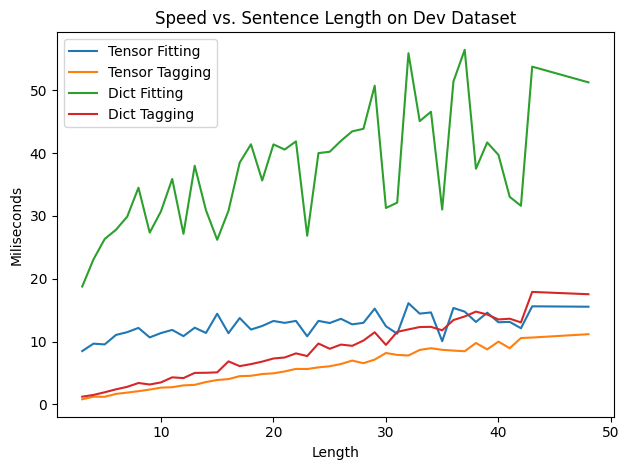

In [ ]:
plt.plot(*fitting_a, label=f"Tensor Fitting")
plt.plot(*tagging_a, label=f"Tensor Tagging")
plt.plot(*fitting_b, label=f"Dict Fitting")
plt.plot(*tagging_b, label=f"Dict Tagging")
plt.ylabel("Miliseconds") ; plt.xlabel("Length")
plt.title("Speed vs. Sentence Length on Dev Dataset")
plt.legend() ; plt.tight_layout()
plt.show()

## Accuracy vs. Size of Training Dataset

----

**Analysis:** We can see that as the size of the training dataset increases, the model's performance gradually improves, but the rate of improvement slows down. This demonstrates that the model has effectively learned the distribution of the dataset. This also confirms the existence of marginal effects.

In [5]:
all_acc, dataset_sizes = list(), list()
model = HmmPosTagger(ALL_POS_TAGS, words_set)
NUM_SPLIT = 10
div, mod = len(train_set["sentences"])//NUM_SPLIT, len(train_set["sentences"])%NUM_SPLIT
beg = 0
for idx in range(1, NUM_SPLIT+1):
    end = div * idx + min(mod, idx)
    model.fit(train_set["sentences"][beg:end], train_set["labels"][beg:end])
    acc, _ = run_tagging(model, test_set["sentences"], test_set["labels"])
    print(f"size={end} {acc=:.4f}%")
    all_acc.append(acc)
    dataset_sizes.append(end)
    beg = end
assert dataset_sizes[-1] == len(train_set["sentences"])

size=1382 acc=75.8362%
size=2764 acc=86.4604%
size=4146 acc=88.2311%
size=5527 acc=89.0002%
size=6908 acc=89.5427%
size=8289 acc=89.8766%
size=9670 acc=90.2045%
size=11051 acc=90.4012%
size=12432 acc=90.6159%
size=13813 acc=90.8007%


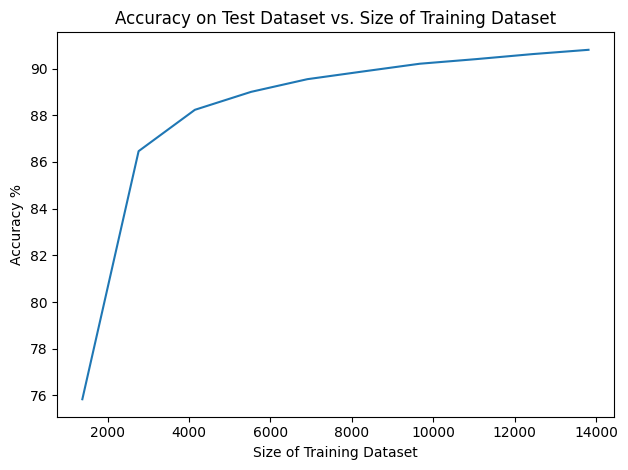

In [ ]:
plt.plot(dataset_sizes, all_acc)
plt.title("Accuracy on Test Dataset vs. Size of Training Dataset")
plt.ylabel("Accuracy %") ; plt.xlabel("Size of Training Dataset")
plt.tight_layout()
plt.show()

## Better Unseen Words Handling: K-Masked Augmentation

A basic idea introdue a special `__UNSEEN__` word represents for all unseen word. And the main problem is how to learn the pos-tag probability of the special word. I used data augmentation to replace words that appear less than `K` time with `__UNSEEN__` to construct new sentences.

It is important to note that these new sentences must be treated as additional data, rather than replacing in the original dataset. Otherwise, it will lead to a performance degradation, as rare words in the training dataset are extremely important for performance.

----

**Analysis:** Overall, performance is showing an improving trend as `K` increases. However, it gradually saturates as `K` increases.

In [ ]:
MAX_K = 50

model = HmmMaskedPosTagger(ALL_POS_TAGS, words_set)
base_ckp = model.fit(train_set["sentences"], train_set["labels"]).export()

words_cnt = dict()
for x in (x for xx in train_set["sentences"] for x in xx):
    words_cnt[x] = words_cnt.get(x, 0) + 1

all_acc, best_acc, best_ckp = list(), 0, dict()
for k in range(MAX_K+1):
    masked_sentences, masked_labels = list(), list()
    for i, orig_sentence in enumerate(train_set["sentences"]):
        cnt = 0
        sentence = [HmmMaskedPosTagger.WORD_UNSEEN] * len(orig_sentence)
        for j, word in enumerate(orig_sentence):
            if words_cnt[word] > k:
                sentence[j] = word
            else:
                cnt += 1
        if cnt > 0:
            masked_sentences.append(sentence)
            masked_labels.append(train_set["labels"][i])
    if k > 0:
        model.load(base_ckp).fit(masked_sentences, masked_labels)
    acc, _ = run_tagging(model, dev_set["sentences"], dev_set["labels"])
    print(f"{k=} {acc=:.4f}%")
    all_acc.append(acc)
    if acc > best_acc:
        best_acc, best_ckp = acc, model.export()

k=0 acc=90.8573%
k=1 acc=91.3635%
k=2 acc=91.5929%
k=3 acc=91.6561%
k=4 acc=91.6640%
k=5 acc=91.6878%
k=6 acc=91.7589%
k=7 acc=91.7985%
k=8 acc=91.7985%
k=9 acc=91.7985%
k=10 acc=91.8301%
k=11 acc=91.8301%
k=12 acc=91.8380%
k=13 acc=91.8380%
k=14 acc=91.8222%
k=15 acc=91.8143%
k=16 acc=91.8143%
k=17 acc=91.8143%
k=18 acc=91.8222%
k=19 acc=91.8222%
k=20 acc=91.8538%
k=21 acc=91.8618%
k=22 acc=91.8459%
k=23 acc=91.8459%
k=24 acc=91.8459%
k=25 acc=91.8459%
k=26 acc=91.8459%
k=27 acc=91.8459%
k=28 acc=91.8459%
k=29 acc=91.8380%
k=30 acc=91.8459%
k=31 acc=91.8380%
k=32 acc=91.8380%
k=33 acc=91.8380%
k=34 acc=91.8380%
k=35 acc=91.8380%
k=36 acc=91.8380%
k=37 acc=91.8380%
k=38 acc=91.8380%
k=39 acc=91.8380%
k=40 acc=91.8380%
k=41 acc=91.8380%
k=42 acc=91.8380%
k=43 acc=91.8380%
k=44 acc=91.8380%
k=45 acc=91.8380%
k=46 acc=91.8380%
k=47 acc=91.8380%
k=48 acc=91.8380%
k=49 acc=91.8380%
k=50 acc=91.8064%


In [8]:
print(f"Best Accuracy on Dev Dataset: {best_acc:.4f}%")
acc, _ = run_tagging(model.load(best_ckp), test_set["sentences"], test_set["labels"])
print(f"Accuracy of Best Model on Test Dataset: {acc:.4f}%")

acc, _ = run_tagging(model.load(base_ckp), test_set["sentences"], test_set["labels"])
print(f"Accuracy of Baseline on Test Dataset: {acc:.4f}%")

Best Accuracy on Dev Dataset: 91.8618%
Accuracy of Best Model on Test Dataset: 91.8500%
Accuracy of Baseline on Test Dataset: 90.8007%


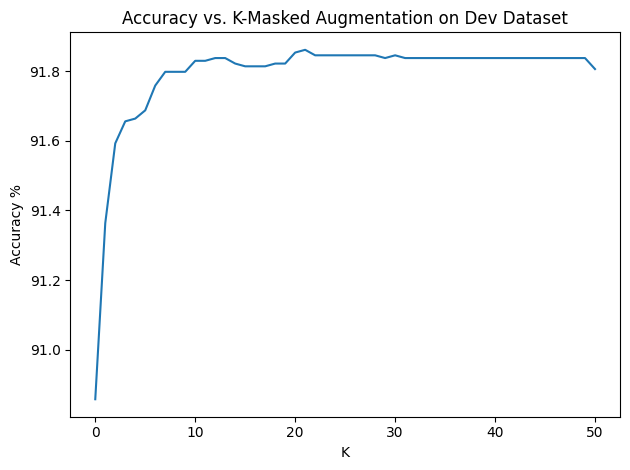

In [ ]:
plt.plot(range(MAX_K+1), all_acc)
plt.ylabel("Accuracy %") ; plt.xlabel("K")
plt.title("Accuracy vs. K-Masked Augmentation on Dev Dataset")
plt.tight_layout()
plt.show()

## N-Gram: Accuracy and Failure vs. Number of Previous States

----

**Analysis:** We can see that as N increases, the performance becomes worse and worse. Furthermore, the model has a higher probability of failing to tag a sentences (because it's more likely to encounter unseen state combinations). Therefore, it is unnecessary to incorporate N-grams into HMM.

In [10]:
all_acc, all_failure_rate, all_n_previous_states = list(), list(), list()
test_size= len(test_set["sentences"])
for n_previous_states in range(1, 10+1):
    model = HmmNgramPosTagger(n_previous_states)
    model.fit(train_set["sentences"], train_set["labels"])

    num_failed, same_cnt, total_length = 0, 0, 0
    for sentence, target in zip(test_set["sentences"], test_set["labels"]):
        try:
            predict = model.tag([sentence])[0]
        except RuntimeError:
            num_failed += 1
            continue
        assert len(predict) == len(target)
        total_length += len(predict)
        for pred, targ in zip(predict, target):
            same_cnt += targ == pred[0]

    acc = same_cnt / total_length * 100
    failure_rate = num_failed / test_size * 100
    print(f"{n_previous_states=} {acc=:.4f}% {failure_rate=:.4f}%")
    all_acc.append(acc)
    all_failure_rate.append(failure_rate)
    all_n_previous_states.append(n_previous_states)
    if all_failure_rate[-1] > 90:
        print(
            f"Early stop at {n_previous_states} because failure rate",
            f"{all_failure_rate[-1]:.4f}% is extremely high",
        )
        break

n_previous_states=1 acc=90.8007% failure_rate=0.0000%
n_previous_states=2 acc=87.0208% failure_rate=0.0000%
n_previous_states=3 acc=83.3507% failure_rate=30.0921%
n_previous_states=4 acc=78.3784% failure_rate=49.3347%
n_previous_states=5 acc=72.8014% failure_rate=65.5067%
n_previous_states=6 acc=68.1208% failure_rate=73.4903%
n_previous_states=7 acc=61.4093% failure_rate=75.5374%
n_previous_states=8 acc=57.1318% failure_rate=74.8209%
n_previous_states=9 acc=54.4787% failure_rate=74.1044%
n_previous_states=10 acc=53.2667% failure_rate=73.6950%


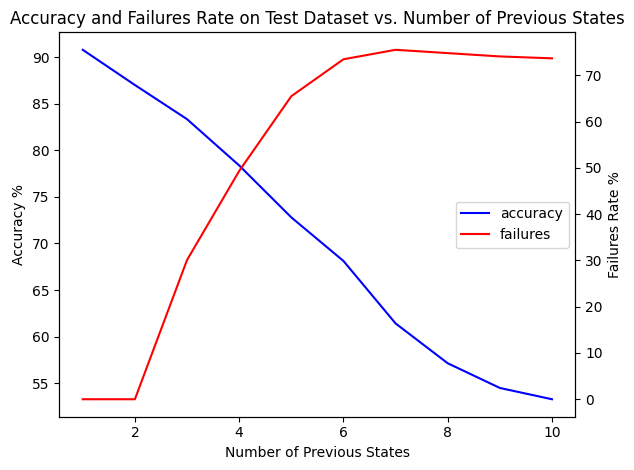

In [ ]:
line_a, = plt.plot(all_n_previous_states, all_acc, c="b", label="accuracy")
plt.ylabel("Accuracy %") ; plt.xlabel("Number of Previous States")
plt.twinx() ; plt.ylabel("Failures Rate %")
line_b, = plt.plot(all_n_previous_states, all_failure_rate, c="r", label="failures")
plt.legend([line_a, line_b], [line_a.get_label(), line_b.get_label()], loc="center right")
plt.title("Accuracy and Failures Rate on Test Dataset vs. Number of Previous States")
plt.tight_layout()
plt.show()

## Parallel: Speed vs. Number of Threads

**IMPORTANT**: To ensure the code produce correct results, you must use python3.14t or later version with free-threaded mode. Otherwise, GIL will limit the performance of multithreading. This will lead to a result that the speed decreases as the number of threads increases!

Jupyter also has some unknown issues resulting in poor parallel performance. Therefore, we will use Python to execute an external script, `./measure_multithreading.py`.

The script will print a table where the `N` column represents the number of threads, with the exception of `DP` and `PT`, which represent the performance of the PyTorch Tensor. Because PyTorch will automatically utilize all the cores on a CPU for computation, testing their multithreading is unnecessary and will generally be slower.

`DP` is a deprecated version. Due to design flaws, it has an extremely high cache missing rate, so its training speed is usually the slowest.

`PT` is a cache-optimized version for matrix writing, utilizing the Locality of Reference principle. It should achieve the fastest speed in every operations.

----

**Analysis:** We can see that, generally, tagging speeds up as the number of threads increases, with some exceptions: The speed when `N=1` is slower than the speed when `N=0`. The same for `N>8` and `N=8`. This is because thread switching requires additional overhead.
- When `N=1`, the overhead increases, but only one thread is tagging like `N=0` (without multithreading).
- When `N>8`, because my poor processor only has 8 cores, additional threads cannot perform computations simultaneously. Instead, they must be scheduled to use the limited cores, which actually slows down the speed.
- Since counting is very fast, we don't need to add multithreading support for fitting, which may actually make it slower due to resource contention.

In [12]:
import subprocess
PYTHON_T_PATH = "../.venv/py314t/Scripts/python"
!"$PYTHON_T_PATH" -V -V

Python 3.14.0 free-threading build (tags/v3.14.0:ebf955d, Oct  7 2025, 10:13:09) [MSC v.1944 64 bit (AMD64)]


In [13]:
max_num_threads = 10
output = subprocess.check_output(
    [PYTHON_T_PATH, "./measure_multithreading.py", "--max_num_threads", str(max_num_threads)],
).decode().strip()
print(output)

|  N |    Total |    Prep. | Training |  Tagging | Cleaning | Accuracy |
|----|----------|----------|----------|----------|----------|----------|
| DP |  5557.29 |     0.00 |  2348.54 |  3208.75 |     0.00 | 90.8007% |
| PT |  3956.97 |     0.00 |   924.91 |  3032.05 |     0.00 | 90.8007% |
|  0 | 15603.15 |     0.00 |  1556.42 | 14046.73 |     0.00 | 90.8007% |
|  1 | 16353.13 |     1.28 |  1634.82 | 14715.56 |     1.47 | 90.8007% |
|  2 |  9746.32 |     2.21 |  1635.93 |  8107.25 |     0.93 | 90.8007% |
|  3 |  7653.47 |     2.40 |  1631.43 |  6017.75 |     1.89 | 90.8007% |
|  4 |  6244.32 |     3.32 |  1631.88 |  4606.79 |     2.33 | 90.8007% |
|  5 |  5820.60 |     3.98 |  1631.87 |  4182.58 |     2.17 | 90.8007% |
|  6 |  5387.19 |     4.31 |  1627.57 |  3754.14 |     1.18 | 90.8007% |
|  7 |  5238.93 |     5.37 |  1633.69 |  3597.89 |     1.99 | 90.8007% |
|  8 |  5138.50 |     5.68 |  1629.35 |  3499.44 |     4.02 | 90.8007% |
|  9 |  5382.12 |     6.33 |  1627.81 |  3746.00 | 

In [14]:
lines = output.split("\n")
heads = lines[0].split(" | ")
assert heads[1].strip() == "Total" and heads[3].strip() == "Training" and heads[4].strip() == "Tagging"
all_total, all_training, all_tagging = list(), list(), list()
for ln in lines[4:]:
    items = ln.split(" | ")
    all_total.append(float(items[1].strip()))
    all_training.append(float(items[3].strip()))
    all_tagging.append(float(items[4].strip()))
assert len(all_total) == max_num_threads + 1

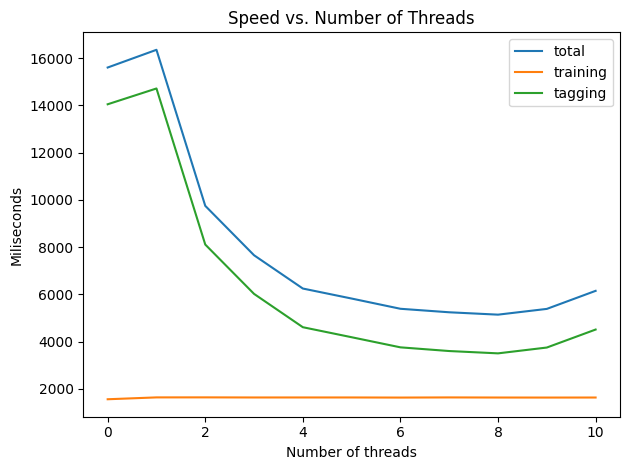

In [ ]:
x_axis = range(max_num_threads + 1)
plt.plot(x_axis, all_total, label="total")
plt.plot(x_axis, all_training, label="training")
plt.plot(x_axis, all_tagging, label="tagging")
plt.ylabel("Miliseconds") ; plt.xlabel("Number of threads")
plt.title("Speed vs. Number of Threads")
plt.legend() ; plt.tight_layout()
plt.show()

## Unsupervised

----

**Analysis:** We can see the log likely hood decrease and normalized mutual info score increase as the model is trained with more epochs. This means that the model learnt the POS distribution of the sentence through unsupervised learning.

In [ ]:
from sklearn.metrics import normalized_mutual_info_score

def unsupervised_scores(predicts: list[list[tuple[str, float]]], targets: list[list[str]]):
    predicts_ = [x[0] for xx in predicts for x in xx]
    targets_ = [x for xx in targets for x in xx]
    nmi = normalized_mutual_info_score(targets_, predicts_)
    return nmi

In [17]:
all_nmi_train, all_nmi_dev, all_nmi_test, all_epochs = list(), list(), list(), list()
model = UnsupervisedHmmPosTagger(len(ALL_POS_TAGS), words_set, init_seed=42)
for epoch in range(1, 100+1):
    model.fit(train_set["sentences"])
    if epoch % 10 == 0:
        all_epochs.append(epoch)
        predicts = model.tag(train_set["sentences"])
        nmi_train = unsupervised_scores(predicts, train_set["labels"])
        all_nmi_train.append(nmi_train)
        predicts = model.tag(dev_set["sentences"])
        nmi_dev = unsupervised_scores(predicts, dev_set["labels"])
        all_nmi_dev.append(nmi_dev)
        predicts = model.tag(test_set["sentences"])
        nmi_test = unsupervised_scores(predicts, test_set["labels"])
        all_nmi_test.append(nmi_test)
        print(f"{epoch=} {nmi_train=:.5e} {nmi_dev=:.5e} {nmi_test=:.5e}")

Log likelyhood: 57.249900817871094
Log likelyhood: -150.9086456298828
Log likelyhood: -150.90682983398438
Log likelyhood: -150.90089416503906
Log likelyhood: -150.88046264648438
Log likelyhood: -150.8195037841797
Log likelyhood: -150.65757751464844
Log likelyhood: -150.3310546875
Log likelyhood: -149.8217315673828
Log likelyhood: -149.21099853515625
epoch=10 nmi_train=4.67297e-02 nmi_dev=5.06644e-02 nmi_test=4.00713e-02
Log likelyhood: -148.6270751953125
Log likelyhood: -148.12216186523438
Log likelyhood: -147.7247772216797
Log likelyhood: -147.4976806640625
Log likelyhood: -147.3834991455078
Log likelyhood: -147.19764709472656
Log likelyhood: -146.8243865966797
Log likelyhood: -146.42178344726562
Log likelyhood: -146.17933654785156
Log likelyhood: -146.0780487060547
epoch=20 nmi_train=7.91585e-02 nmi_dev=8.10379e-02 nmi_test=6.70021e-02
Log likelyhood: -146.02882385253906
Log likelyhood: -145.9874267578125
Log likelyhood: -145.93516540527344
Log likelyhood: -145.85415649414062
Log lik

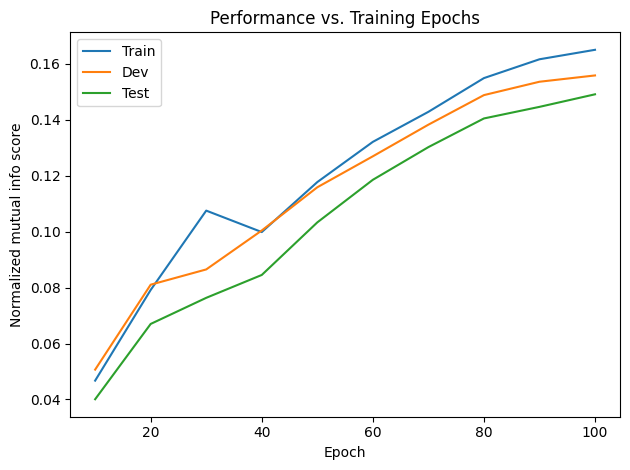

In [ ]:
plt.plot(all_epochs, all_nmi_train, label="Train")
plt.plot(all_epochs, all_nmi_dev, label="Dev")
plt.plot(all_epochs, all_nmi_test, label="Test")
plt.title("Performance vs. Training Epochs")
plt.ylabel("Normalized mutual info score") ; plt.xlabel("Epoch")
plt.legend() ; plt.tight_layout()
plt.show()